1. Lead Scoring (Classification)

    Problem: Classify whether a lead will convert into a sale (binary classification: converted vs. not converted).
    Potential Features: origin, lead_type, lead_behaviour_profile, business_segment, declared_monthly_revenue, etc.
    Target: won_date (presence/absence can indicate if the lead was converted).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.cluster import KMeans
import pingouin as pg
import plotly.express as px 
import plotly.io as pio
pio.renderers.default='notebook'
import prince
from scipy.stats import chi2_contingency
from sklearn.metrics import silhouette_score
import statsmodels.api as sm # estimação de modelos

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

In [3]:
closed_deals_data  = pd.read_csv('/home/marketing-analytics/datasets/olist_closed_deals_dataset.csv')
qualified_leads_data = pd.read_csv('/home/marketing-analytics/datasets/olist_marketing_qualified_leads_dataset.csv')

In [4]:
closed_deals_data.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0


In [5]:
qualified_leads_data.head()

,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


In [6]:
# Merge the closed deals and qualified leads datasets on 'mql_id'
merged_leads_data = pd.merge(qualified_leads_data, closed_deals_data, on='mql_id', how='left')

# Create the 'converted' column (1 if 'won_date' is present, 0 otherwise)
merged_leads_data['converted'] = merged_leads_data['won_date'].notnull().astype(int)

In [8]:
merged_leads_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mql_id,8000,8000,8723201570415eb23b4f095d8c20a27c,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_contact_date,8000,336,2018-05-02,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
landing_page_id,8000,495,b76ef37428e6799c421989521c0e5077,912,NaN,NaN,NaN,NaN,NaN,NaN,NaN
origin,7940,10,organic_search,2296,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_id,842,842,1bba9c94eb5c4e82fba9f7286fe81025,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sdr_id,842,32,4b339f9567d060bcea4f5136b9f5949e,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sr_id,842,22,4ef15afb4b2723d8f3d81e51ec7afefe,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
won_date,842,824,2018-05-04 03:00:00,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
business_segment,841,33,home_decor,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_type,836,8,online_medium,332,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [265]:
merged_leads_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id                         8000 non-null   object 
 1   first_contact_date             8000 non-null   object 
 2   landing_page_id                8000 non-null   object 
 3   origin                         7940 non-null   object 
 4   seller_id                      842 non-null    object 
 5   sdr_id                         842 non-null    object 
 6   sr_id                          842 non-null    object 
 7   won_date                       842 non-null    object 
 8   business_segment               841 non-null    object 
 9   lead_type                      836 non-null    object 
 10  lead_behaviour_profile         665 non-null    object 
 11  has_company                    63 non-null     object 
 12  has_gtin                       64 non-null     o

In [266]:
merged_leads_data.isna().sum()

mql_id                              0
first_contact_date                  0
landing_page_id                     0
origin                             60
seller_id                        7158
sdr_id                           7158
sr_id                            7158
won_date                         7158
business_segment                 7159
lead_type                        7164
lead_behaviour_profile           7335
has_company                      7937
has_gtin                         7936
average_stock                    7934
business_type                    7168
declared_product_catalog_size    7931
declared_monthly_revenue         7158
converted                           0
dtype: int64

In [9]:
# Drop unnecessary columns after merging
columns_to_drop_after_merge = ['seller_id', 'sdr_id', 'sr_id', 'won_date', 
                               'first_contact_date', 'landing_page_id']
merged_leads_data_clean = merged_leads_data.drop(columns=columns_to_drop_after_merge)

# Fill missing values as before for consistency
merged_leads_data_clean.fillna({
    'origin': 'unknown',
    'lead_type': 'unknown',
    'lead_behaviour_profile': 'unknown',
    'business_segment': 'unknown',
    'has_company': 'unknown',
    'has_gtin': 'unknown',
    'average_stock': 0,
    'business_type': 'unknown',
    'declared_product_catalog_size': 0,
    'declared_monthly_revenue': 0
}, inplace=True)

# Convert categorical variables to categorical type
#categorical_columns_merge = ['origin', 'lead_type', 'lead_behaviour_profile', 'business_segment', 
#                             'has_company', 'has_gtin', 'business_type']
#merged_leads_data_clean[categorical_columns_merge] = merged_leads_data_clean[categorical_columns_merge].astype('category')

# Display the cleaned merged dataset
merged_leads_data_clean.head()

,mql_id,origin,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,converted
0,dac32acd4db4c29c230538b72f8dd87d,social,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,paid_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
2,b4bc852d233dfefc5131f593b538befa,organic_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
3,6be030b81c75970747525b843c1ef4f8,email,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
4,5420aad7fec3549a85876ba1c529bd84,organic_search,pet,online_medium,cat,unknown,unknown,0,reseller,0.0,0.0,1


In [10]:
merged_leads_data_clean.isna().sum()

mql_id                           0
origin                           0
business_segment                 0
lead_type                        0
lead_behaviour_profile           0
has_company                      0
has_gtin                         0
average_stock                    0
business_type                    0
declared_product_catalog_size    0
declared_monthly_revenue         0
converted                        0
dtype: int64

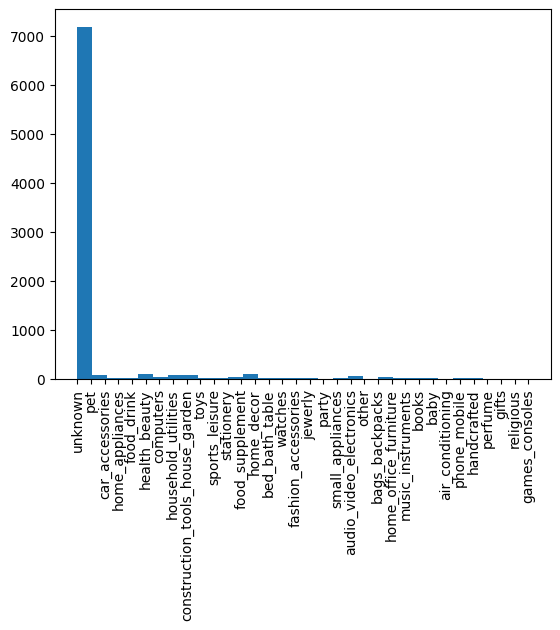

In [11]:
merged_leads_data_clean['business_segment'].hist(bins=30, grid=False)
plt.xticks(rotation=90)
plt.show()

In [12]:
merged_leads_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id                         8000 non-null   object 
 1   origin                         8000 non-null   object 
 2   business_segment               8000 non-null   object 
 3   lead_type                      8000 non-null   object 
 4   lead_behaviour_profile         8000 non-null   object 
 5   has_company                    8000 non-null   object 
 6   has_gtin                       8000 non-null   object 
 7   average_stock                  8000 non-null   object 
 8   business_type                  8000 non-null   object 
 9   declared_product_catalog_size  8000 non-null   float64
 10  declared_monthly_revenue       8000 non-null   float64
 11  converted                      8000 non-null   int64  
dtypes: float64(2), int64(1), object(9)
memory usage:

In [13]:
merged_leads_data_clean.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mql_id,8000,8000,8723201570415eb23b4f095d8c20a27c,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
origin,8000,10,organic_search,2296,NaN,NaN,NaN,NaN,NaN,NaN,NaN
business_segment,8000,34,unknown,7159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_type,8000,9,unknown,7164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_behaviour_profile,8000,10,unknown,7335,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_company,8000,3,unknown,7937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_gtin,8000,3,unknown,7936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_stock,8000.0,7.0,0.0,7934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
business_type,8000,4,unknown,7168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
declared_product_catalog_size,8000.0,NaN,NaN,NaN,2.009875,38.986819,0.0,0.0,0.0,0.0,2000.0


In [14]:
# Step 1: Encoding categorical variables using one-hot encoding
encoded_merged_data = pd.get_dummies(merged_leads_data_clean.drop(columns=['mql_id']), drop_first=True)

In [15]:
# Step 2: Split the data into features (X) and target (y)
X_merged = encoded_merged_data.drop(columns=['converted'])
y_merged = encoded_merged_data['converted']

# Step 3: Split the data into training and test sets (80% training, 20% testing)
X_train_merged, X_test_merged, y_train_merged, y_test_merged = train_test_split(X_merged, y_merged, test_size=0.2, random_state=42)

# Step 4: Train a Logistic Regression model
logreg_merged = LogisticRegression(max_iter=1000)
logreg_merged.fit(X_train_merged, y_train_merged)

# Step 5: Evaluate the model on the test set
y_pred_merged = logreg_merged.predict(X_test_merged)
classification_report_merged = classification_report(y_test_merged, y_pred_merged)

# Display the classification report for model evaluation
print(classification_report_merged)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1451
           1       1.00      1.00      1.00       149

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



#############################

### SMOTE

In [16]:
# Split the data into features (X) and target (y)
X_merged = encoded_merged_data.drop(columns=['converted'])
y_merged = encoded_merged_data['converted']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_merged, y_merged, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a model (Logistic Regression in this example)
model = LogisticRegression()
model.fit(X_train_smote, y_train_smote)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1451
           1       1.00      1.00      1.00       149

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



### Logistic Binary Model

Let's start again. I thin the category is making some mess here.

In [17]:
encoded_merged_data

,declared_product_catalog_size,declared_monthly_revenue,converted,origin_display,origin_email,origin_organic_search,origin_other,origin_other_publicities,origin_paid_search,origin_referral,...,has_gtin_unknown,average_stock_1-5,average_stock_20-50,average_stock_200+,average_stock_5-20,average_stock_50-200,average_stock_unknown,business_type_other,business_type_reseller,business_type_unknown
0,0.0,0.0,0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
1,0.0,0.0,0,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
2,0.0,0.0,0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
3,0.0,0.0,0,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,0.0,0.0,1,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.0,0.0,0,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
7996,0.0,0.0,0,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
7997,0.0,0.0,0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
7998,0.0,0.0,0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True


In [18]:
merged_leads_data_clean

,mql_id,origin,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,converted
0,dac32acd4db4c29c230538b72f8dd87d,social,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,paid_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
2,b4bc852d233dfefc5131f593b538befa,organic_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
3,6be030b81c75970747525b843c1ef4f8,email,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
4,5420aad7fec3549a85876ba1c529bd84,organic_search,pet,online_medium,cat,unknown,unknown,0,reseller,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7995,feaba3ffcd2ff97501696c7f9a42f41c,paid_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
7996,a79cb53cd009ab92e0143b92baa2407b,paid_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
7997,68f049a23ab109c6a0f6989bb9a02994,organic_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
7998,4f8c96e2509b984329044c6682c88ee9,organic_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0


In [19]:
encoded_merged_data_2 = pd.get_dummies(merged_leads_data_clean.drop(columns=['mql_id']), drop_first=True, dummy_na=True)

In [20]:
encoded_merged_data_2

,declared_product_catalog_size,declared_monthly_revenue,converted,origin_display,origin_email,origin_organic_search,origin_other,origin_other_publicities,origin_paid_search,origin_referral,...,average_stock_20-50,average_stock_200+,average_stock_5-20,average_stock_50-200,average_stock_unknown,average_stock_nan,business_type_other,business_type_reseller,business_type_unknown,business_type_nan
0,0.0,0.0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,0.0,0.0,0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,0.0,0.0,0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0.0,0.0,0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,0.0,0.0,1,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.0,0.0,0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
7996,0.0,0.0,0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
7997,0.0,0.0,0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
7998,0.0,0.0,0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [21]:
# Identify boolean columns
boolean_columns = encoded_merged_data_2.select_dtypes(include='bool').columns

# Convert boolean columns to integers
encoded_merged_data_2[boolean_columns] = encoded_merged_data_2[boolean_columns].astype(int)

In [22]:
encoded_merged_data_2

,declared_product_catalog_size,declared_monthly_revenue,converted,origin_display,origin_email,origin_organic_search,origin_other,origin_other_publicities,origin_paid_search,origin_referral,...,average_stock_20-50,average_stock_200+,average_stock_5-20,average_stock_50-200,average_stock_unknown,average_stock_nan,business_type_other,business_type_reseller,business_type_unknown,business_type_nan
0,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,0.0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7996,0.0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7997,0.0,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7998,0.0,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [23]:
encoded_merged_data_2.columns = encoded_merged_data_2.columns.str.replace('_', '-')

In [24]:
encoded_merged_data_2.columns

Index(['declared-product-catalog-size', 'declared-monthly-revenue',
       'converted', 'origin-display', 'origin-email', 'origin-organic-search',
       'origin-other', 'origin-other-publicities', 'origin-paid-search',
       'origin-referral', 'origin-social', 'origin-unknown', 'origin-nan',
       'business-segment-audio-video-electronics', 'business-segment-baby',
       'business-segment-bags-backpacks', 'business-segment-bed-bath-table',
       'business-segment-books', 'business-segment-car-accessories',
       'business-segment-computers',
       'business-segment-construction-tools-house-garden',
       'business-segment-fashion-accessories', 'business-segment-food-drink',
       'business-segment-food-supplement', 'business-segment-games-consoles',
       'business-segment-gifts', 'business-segment-handcrafted',
       'business-segment-health-beauty', 'business-segment-home-appliances',
       'business-segment-home-decor', 'business-segment-home-office-furniture',
       'b

In [25]:
columns_list = list(encoded_merged_data_2.drop(columns=['converted']).columns)

encoded_model_2 = " + ".join(columns_list)
encoded_model_2 = "converted ~ " + encoded_model_2
print('Used on Formula: ', encoded_model_2)

Used on Formula:  converted ~ declared-product-catalog-size + declared-monthly-revenue + origin-display + origin-email + origin-organic-search + origin-other + origin-other-publicities + origin-paid-search + origin-referral + origin-social + origin-unknown + origin-nan + business-segment-audio-video-electronics + business-segment-baby + business-segment-bags-backpacks + business-segment-bed-bath-table + business-segment-books + business-segment-car-accessories + business-segment-computers + business-segment-construction-tools-house-garden + business-segment-fashion-accessories + business-segment-food-drink + business-segment-food-supplement + business-segment-games-consoles + business-segment-gifts + business-segment-handcrafted + business-segment-health-beauty + business-segment-home-appliances + business-segment-home-decor + business-segment-home-office-furniture + business-segment-household-utilities + business-segment-jewerly + business-segment-music-instruments + business-segment-

In [26]:
encoded_model_2

'converted ~ declared-product-catalog-size + declared-monthly-revenue + origin-display + origin-email + origin-organic-search + origin-other + origin-other-publicities + origin-paid-search + origin-referral + origin-social + origin-unknown + origin-nan + business-segment-audio-video-electronics + business-segment-baby + business-segment-bags-backpacks + business-segment-bed-bath-table + business-segment-books + business-segment-car-accessories + business-segment-computers + business-segment-construction-tools-house-garden + business-segment-fashion-accessories + business-segment-food-drink + business-segment-food-supplement + business-segment-games-consoles + business-segment-gifts + business-segment-handcrafted + business-segment-health-beauty + business-segment-home-appliances + business-segment-home-decor + business-segment-home-office-furniture + business-segment-household-utilities + business-segment-jewerly + business-segment-music-instruments + business-segment-other + business-

In [28]:
# The model
#converted_model = sm.Logit.from_formula(encoded_model_2, encoded_merged_data_2).fit()
#converted_model.summary()

Hum, vamos testar com algumas features isso.

In [29]:
merged_leads_data_clean.columns

Index(['mql_id', 'origin', 'business_segment', 'lead_type',
       'lead_behaviour_profile', 'has_company', 'has_gtin', 'average_stock',
       'business_type', 'declared_product_catalog_size',
       'declared_monthly_revenue', 'converted'],
      dtype='object')

In [30]:
encoded_merged_data_small = pd.get_dummies(merged_leads_data_clean.drop(columns=[
       'mql_id', 'business_segment', 'lead_type',
       'lead_behaviour_profile', 'has_company', 'has_gtin', 'average_stock',
       'business_type', 'declared_product_catalog_size',
       'declared_monthly_revenue', 
       ]), drop_first=True)

In [31]:
encoded_merged_data_small

,converted,origin_display,origin_email,origin_organic_search,origin_other,origin_other_publicities,origin_paid_search,origin_referral,origin_social,origin_unknown
0,0,False,False,False,False,False,False,False,True,False
1,0,False,False,False,False,False,True,False,False,False
2,0,False,False,True,False,False,False,False,False,False
3,0,False,True,False,False,False,False,False,False,False
4,1,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
7995,0,False,False,False,False,False,True,False,False,False
7996,0,False,False,False,False,False,True,False,False,False
7997,0,False,False,True,False,False,False,False,False,False
7998,0,False,False,True,False,False,False,False,False,False


In [32]:
# Identify boolean columns
boolean_columns = encoded_merged_data_small.select_dtypes(include='bool').columns

# Convert boolean columns to integers
encoded_merged_data_small[boolean_columns] = encoded_merged_data_small[boolean_columns].astype(int)

In [33]:
encoded_merged_data_small

,converted,origin_display,origin_email,origin_organic_search,origin_other,origin_other_publicities,origin_paid_search,origin_referral,origin_social,origin_unknown
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7995,0,0,0,0,0,0,1,0,0,0
7996,0,0,0,0,0,0,1,0,0,0
7997,0,0,0,1,0,0,0,0,0,0
7998,0,0,0,1,0,0,0,0,0,0


Used on Formula:  converted ~ origin_display + origin_email + origin_organic_search + origin_other + origin_other_publicities + origin_paid_search + origin_referral + origin_social + origin_unknown


In [35]:
columns_list = list(encoded_merged_data_small.drop(columns=['converted']).columns)

encoded_model_small = " + ".join(columns_list)
encoded_model_small = "converted ~ " + encoded_model_small


# The model
converted_model_small = sm.Logit.from_formula(encoded_model_small, encoded_merged_data_small).fit()
converted_model_small.summary()

Optimization terminated successfully.
         Current function value: 0.326894
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7990
Method:                           MLE   Df Model:                            9
Date:                Sat, 26 Oct 2024   Pseudo R-squ.:                 0.02845
Time:                        17:11:23   Log-Likelihood:                -2615.2
converged:                       True   LL-Null:                       -2691.7
Covariance Type:            nonrobust   LLR p-value:                 1.940e-28
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.0682      0.142    -14.583      0.000      -2.346      -1.790
origin_display              -0.8585      0.442     -1.941      0.052      -1.726       0.009
origin_email                -1.3933      0.298     -4.674      0.000      -1.978      -0.809
origin_organic_search        0.0570      0.156      0.366      0.715      -0.249       0.363
origin_other                -1.5291      0.526     -2.906      0.004      -2.561      -0.498
origin_other_publicities    -0.9603      0.608     -1.580      0.114      -2.152       0.231
origin_paid_search           0.1034      0.161      0.642      0.521      -0.212       0.419
origin_referral             -0.3144      0.256     -1.227      0.220      -0.817       0.188
origin_social               -0.7650      0.185     -4.135      0.000      -1.128      -0.402
origin_unknown               0.4577      0.162      2.821      0.005       0.140       0.776
============================================================================================
"""

In [36]:
# Loglike
converted_model_small.llf

np.float64(-2615.154071920609)

In [37]:
# Modelo Nulo
modelo_nulo = sm.Logit.from_formula('converted ~ 1',
                                              data=encoded_merged_data_small).fit()
modelo_nulo.summary()

Optimization terminated successfully.
         Current function value: 0.336468
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7999
Method:                           MLE   Df Model:                            0
Date:                Sat, 26 Oct 2024   Pseudo R-squ.:               4.726e-11
Time:                        17:11:23   Log-Likelihood:                -2691.7
converged:                       True   LL-Null:                       -2691.7
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1402      0.036    -58.744      0.000      -2.212      -2.069
==============================================================================
"""

Estimação do modelo Logístico Multinomial

In [38]:
x = encoded_merged_data_small.drop(columns=['converted'])
y = encoded_merged_data_small['converted']

# Esse pacote precisa que a constante seja definida pelo usuário
X = sm.add_constant(x)

In [39]:
from statsmodels.discrete.discrete_model import MNLogit # estimação do modelo


In [40]:
# Estimação do modelo - função 'MNLogit' ('statsmodels.discrete.discrete_model')
modelo_convertido = MNLogit(endog=y, exog=X).fit()

# Parâmetros do modelo 'modelo_atrasado'
modelo_convertido.summary()

Optimization terminated successfully.
         Current function value: 0.326894
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              converted   No. Observations:                 8000
Model:                        MNLogit   Df Residuals:                     7990
Method:                           MLE   Df Model:                            9
Date:                Sat, 26 Oct 2024   Pseudo R-squ.:                 0.02845
Time:                        17:11:23   Log-Likelihood:                -2615.2
converged:                       True   LL-Null:                       -2691.7
Covariance Type:            nonrobust   LLR p-value:                 1.940e-28
============================================================================================
             converted=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.0682      0.142    -14.583      0.000      -2.346      -1.790
origin_display              -0.8585      0.442     -1.941      0.052      -1.726       0.009
origin_email                -1.3933      0.298     -4.674      0.000      -1.978      -0.809
origin_organic_search        0.0570      0.156      0.366      0.715      -0.249       0.363
origin_other                -1.5291      0.526     -2.906      0.004      -2.561      -0.498
origin_other_publicities    -0.9603      0.608     -1.580      0.114      -2.152       0.231
origin_paid_search           0.1034      0.161      0.642      0.521      -0.212       0.419
origin_referral             -0.3144      0.256     -1.227      0.220      -0.817       0.188
origin_social               -0.7650      0.185     -4.135      0.000      -1.128      -0.402
origin_unknown               0.4577      0.162      2.821      0.005       0.140       0.776
============================================================================================
"""

In [41]:
encoded_merged_data_small['converted'].value_counts(normalize=True)

converted
0    0.89475
1    0.10525
Name: proportion, dtype: float64

A diferença entre os resultados é muito grande, praticamente 10% da base está categorizada como lead qualificado para o marketing.

Try Synthetic Minority Over-sampling Technique (SMOTE): Generate synthetic samples by interpolating between minority class examples.

In [42]:
encoded_merged_data_small

,converted,origin_display,origin_email,origin_organic_search,origin_other,origin_other_publicities,origin_paid_search,origin_referral,origin_social,origin_unknown
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7995,0,0,0,0,0,0,1,0,0,0
7996,0,0,0,0,0,0,1,0,0,0
7997,0,0,0,1,0,0,0,0,0,0
7998,0,0,0,1,0,0,0,0,0,0


In [43]:
# Split the data into features (X) and target (y)
X_merged = encoded_merged_data_small.drop(columns=['converted'])
y_merged = encoded_merged_data_small['converted']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_merged, y_merged, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a model (Logistic Regression in this example)
model = LogisticRegression()
model.fit(X_train_smote, y_train_smote)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.32      0.48      1451
           1       0.12      0.87      0.20       149

    accuracy                           0.37      1600
   macro avg       0.54      0.59      0.34      1600
weighted avg       0.88      0.37      0.46      1600



The model is over-predicting the minority class (class 1), resulting in:
- High recall but low precision for class 1.
- Low recall but high precision for class 0.

The overall accuracy is only 37%, which is significantly lower than the baseline accuracy you'd get by always predicting the majority class (which would be ~89%).

Recommendations ##############

1. Ensure Correct Use of SMOTE:
        Apply SMOTE Only to the Training Data:

2. Adjust the Classification Threshold:

    Since the default threshold may not be suitable, you can adjust it based on the ROC curve or precision-recall curve to find a balance between precision and recall.

3. Use Class Weights in Logistic Regression:

4. Modify the model to give higher weight to the minority class.

    Try Different Models:

    Random Forest or Gradient Boosting algorithms can handle imbalanced datasets better.

5. Evaluate with Appropriate Metrics:

    Since accuracy is not informative for imbalanced datasets, focus on:
        Precision, Recall, F1-Score for each class.
        ROC AUC Score

6. Cross-Validation with Stratification:

    Ensure that each fold in cross-validation has the same class distribution

7. Use a Pipeline to Prevent Data Leakage:

    Integrate SMOTE within a pipeline that also includes scaling and model fitting. 

8. Hyperparameter Tuning:

    Use GridSearchCV or RandomizedSearchCV to find the best parameters for your model.

9. Analyze Feature Importance:

    Understanding which features contribute most can help improve the model.

10. Consider Alternative Resampling Techniques
- ADASYN: Focuses on harder-to-learn examples.
- Combination of Over- and Undersampling:

In [52]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [53]:
# 1. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_merged, y_merged, test_size=0.2, stratify=y, random_state=42)

# 2. Create a pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

# 3. Cross-validation with stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Train the model
pipeline.fit(X_train, y_train)

# 5. Predict on the test set
y_pred = pipeline.predict(X_test)
y_scores = pipeline.predict_proba(X_test)[:, 1]

# 6. Evaluate the model
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_scores)
print(f'ROC AUC Score: {roc_auc}')

# 7. Adjust the classification threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
# Find the threshold that gives the best F1-Score or balance between precision and recall

              precision    recall  f1-score   support

           0       0.96      0.32      0.48      1432
           1       0.13      0.88      0.23       168

    accuracy                           0.38      1600
   macro avg       0.54      0.60      0.35      1600
weighted avg       0.87      0.38      0.45      1600

ROC AUC Score: 0.6038798550146316


In [54]:

# 1. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_merged, y_merged, test_size=0.2, stratify=y, random_state=42)

# 2. Create a pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 3. Cross-validation with stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Train the model
pipeline.fit(X_train, y_train)

# 5. Predict on the test set
y_pred = pipeline.predict(X_test)
y_scores = pipeline.predict_proba(X_test)[:, 1]

# 6. Evaluate the model
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_scores)
print(f'ROC AUC Score: {roc_auc}')

# 7. Adjust the classification threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
# Find the threshold that gives the best F1-Score or balance between precision and recall

              precision    recall  f1-score   support

           0       0.96      0.32      0.48      1432
           1       0.13      0.88      0.23       168

    accuracy                           0.38      1600
   macro avg       0.54      0.60      0.35      1600
weighted avg       0.87      0.38      0.45      1600

ROC AUC Score: 0.6028697791965949


Alternative Resampling Techniques

In [55]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)

In [56]:
# 1. Split the dataset
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# 2. Create a pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 3. Cross-validation with stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Train the model
pipeline.fit(X_train_resampled, y_train_resampled)

# 5. Predict on the test set
y_pred = pipeline.predict(X_test)
y_scores = pipeline.predict_proba(X_test)[:, 1]

# 6. Evaluate the model
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_scores)
print(f'ROC AUC Score: {roc_auc}')

# 7. Adjust the classification threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
# Find the threshold that gives the best F1-Score or balance between precision and recall

              precision    recall  f1-score   support

           0       0.96      0.32      0.48      1432
           1       0.13      0.88      0.23       168

    accuracy                           0.38      1600
   macro avg       0.54      0.60      0.35      1600
weighted avg       0.87      0.38      0.45      1600

ROC AUC Score: 0.6053804203245544


In [57]:
# 1. Split the dataset
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# 2. Create a pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

# 3. Cross-validation with stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Train the model
pipeline.fit(X_train_resampled, y_train_resampled)

# 5. Predict on the test set
y_pred = pipeline.predict(X_test)
y_scores = pipeline.predict_proba(X_test)[:, 1]

# 6. Evaluate the model
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_scores)
print(f'ROC AUC Score: {roc_auc}')

# 7. Adjust the classification threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
# Find the threshold that gives the best F1-Score or balance between precision and recall

              precision    recall  f1-score   support

           0       0.96      0.32      0.48      1432
           1       0.13      0.88      0.23       168

    accuracy                           0.38      1600
   macro avg       0.54      0.60      0.35      1600
weighted avg       0.87      0.38      0.45      1600

ROC AUC Score: 0.6053804203245544


############## Rebalanceando Manualmente o dataset ################

In [59]:
encoded_merged_data_small['converted'].value_counts()

converted
0    7158
1     842
Name: count, dtype: int64

In [66]:
df1 = encoded_merged_data_small[encoded_merged_data_small['converted'] == 1]

In [67]:
df1

,converted,origin_display,origin_email,origin_organic_search,origin_other,origin_other_publicities,origin_paid_search,origin_referral,origin_social,origin_unknown
4,1,0,0,1,0,0,0,0,0,0
12,1,0,0,0,0,0,0,1,0,0
14,1,0,0,1,0,0,0,0,0,0
39,1,0,0,0,0,0,1,0,0,0
67,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
7978,1,0,0,1,0,0,0,0,0,0
7983,1,0,0,1,0,0,0,0,0,0
7991,1,0,0,0,0,0,1,0,0,0
7994,1,0,0,0,0,0,0,0,1,0


In [68]:
df2 = encoded_merged_data_small[encoded_merged_data_small['converted'] == 0]

In [69]:
df2 = df2.sample(n=842, random_state=42)

In [70]:
df2

,converted,origin_display,origin_email,origin_organic_search,origin_other,origin_other_publicities,origin_paid_search,origin_referral,origin_social,origin_unknown
2093,0,0,0,0,0,0,1,0,0,0
5977,0,0,0,0,0,0,0,0,0,1
262,0,0,0,0,0,0,0,0,0,1
7807,0,0,0,0,0,0,0,0,1,0
6362,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1209,0,0,0,0,0,0,0,0,0,0
3989,0,0,0,0,0,0,0,0,1,0
3146,0,0,1,0,0,0,0,0,0,0
3067,0,0,0,0,0,1,0,0,0,0


In [78]:
balanced_df = pd.merge(df1, df2, how='outer')

In [80]:
balanced_df.shape

(1684, 10)

In [81]:
balanced_df['converted'].value_counts()

converted
0    842
1    842
Name: count, dtype: int64

Model 

In [84]:
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário

In [85]:
# Prepare the columns
columns_list = list(balanced_df.drop(columns=['converted']).columns)

balanced_model_columns = " + ".join(columns_list)
balanced_model_columns = "converted ~ " + balanced_model_columns


# The model
balanced_model = smf.glm(formula=balanced_model_columns, 
                         data=balanced_df,
                         family=sm.families.Binomial()).fit()
balanced_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 1684
Model:                            GLM   Df Residuals:                     1674
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1133.7
Date:                Sat, 26 Oct 2024   Deviance:                       2267.4
Time:                        18:03:10   Pearson chi2:                 1.68e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03905
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0935      0.194      0.483      0.629      -0.286       0.473
origin_display              -0.2477      0.589     -0.420      0.674      -1.402       0.907
origin_email                -1.3173      0.352     -3.745      0.000      -2.007      -0.628
origin_organic_search       -0.0636      0.212     -0.300      0.764      -0.479       0.352
origin_other                -1.4153      0.595     -2.378      0.017      -2.582      -0.249
origin_other_publicities    -0.7867      0.733     -1.073      0.283      -2.224       0.650
origin_paid_search           0.0496      0.220      0.225      0.822      -0.382       0.481
origin_referral             -0.1736      0.343     -0.506      0.613      -0.846       0.499
origin_social               -0.6887      0.241     -2.856      0.004      -1.161      -0.216
origin_unknown               0.3985      0.226      1.762      0.078      -0.045       0.842
============================================================================================
"""

Loglik ficou bem melhor agora com esse balanceamento dos dados, porém várias features não passam pelo p-value

Let's add more features

In [95]:
print(encoded_merged_data.dtypes)

declared_product_catalog_size    float64
declared_monthly_revenue         float64
converted                          int64
origin_display                      bool
origin_email                        bool
                                  ...   
average_stock_50-200                bool
average_stock_unknown               bool
business_type_other                 bool
business_type_reseller              bool
business_type_unknown               bool
Length: 75, dtype: object


In [96]:


encoded_merged_data.head()

,declared_product_catalog_size,declared_monthly_revenue,converted,origin_display,origin_email,origin_organic_search,origin_other,origin_other_publicities,origin_paid_search,origin_referral,...,has_gtin_unknown,average_stock_1-5,average_stock_20-50,average_stock_200+,average_stock_5-20,average_stock_50-200,average_stock_unknown,business_type_other,business_type_reseller,business_type_unknown
0,0.0,0.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0.0,0.0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,0.0,0.0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,0.0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0.0,0.0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [99]:
merged_leads_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id                         8000 non-null   object 
 1   origin                         8000 non-null   object 
 2   business_segment               8000 non-null   object 
 3   lead_type                      8000 non-null   object 
 4   lead_behaviour_profile         8000 non-null   object 
 5   has_company                    8000 non-null   object 
 6   has_gtin                       8000 non-null   object 
 7   average_stock                  8000 non-null   object 
 8   business_type                  8000 non-null   object 
 9   declared_product_catalog_size  8000 non-null   float64
 10  declared_monthly_revenue       8000 non-null   float64
 11  converted                      8000 non-null   int64  
dtypes: float64(2), int64(1), object(9)
memory usage:

In [100]:
merged_leads_data_clean.head()

,mql_id,origin,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,converted
0,dac32acd4db4c29c230538b72f8dd87d,social,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,paid_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
2,b4bc852d233dfefc5131f593b538befa,organic_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
3,6be030b81c75970747525b843c1ef4f8,email,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
4,5420aad7fec3549a85876ba1c529bd84,organic_search,pet,online_medium,cat,unknown,unknown,0,reseller,0.0,0.0,1


In [153]:
clean_df1 = merged_leads_data_clean[merged_leads_data_clean['converted'] == 1]
clean_df2 = merged_leads_data_clean[merged_leads_data_clean['converted'] == 0]
clean_df2 = clean_df2.sample(n=len(clean_df1), random_state=42)

balanced_df = pd.merge(clean_df1, clean_df2, how='outer')
balanced_df['converted'].value_counts()

converted
1    842
0    842
Name: count, dtype: int64

In [107]:
balanced_df.tail()

,mql_id,origin,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,converted
1679,ff8ee6aac61c11f16443646cdf467146,direct_traffic,car_accessories,industry,cat,unknown,unknown,0,manufacturer,0.0,0.0,1
1680,ffbab8235ddc5c0290ecd6ceccc0a61a,paid_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
1681,ffdd99e05df27c02a2fb1669d49e0c76,organic_search,sports_leisure,online_medium,eagle,unknown,unknown,0,reseller,0.0,0.0,1
1682,ffe640179b554e295c167a2f6be528e0,unknown,home_appliances,industry,wolf,unknown,unknown,0,manufacturer,0.0,0.0,1
1683,fff8db9478d2fd72df65a67ee6b62f67,direct_traffic,construction_tools_house_garden,online_medium,unknown,unknown,unknown,0,reseller,0.0,0.0,1


In [103]:
balanced_df.columns

Index(['mql_id', 'origin', 'business_segment', 'lead_type',
       'lead_behaviour_profile', 'has_company', 'has_gtin', 'average_stock',
       'business_type', 'declared_product_catalog_size',
       'declared_monthly_revenue', 'converted'],
      dtype='object')

In [108]:
balanced_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mql_id,1684,1684,fff8db9478d2fd72df65a67ee6b62f67,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
origin,1684,10,organic_search,534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
business_segment,1684,34,unknown,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_type,1684,9,unknown,848,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_behaviour_profile,1684,10,unknown,1019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_company,1684,3,unknown,1621,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_gtin,1684,3,unknown,1620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_stock,1684.0,7.0,0.0,1618.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
business_type,1684,4,unknown,852,NaN,NaN,NaN,NaN,NaN,NaN,NaN
declared_product_catalog_size,1684.0,NaN,NaN,NaN,9.5481,84.570317,0.0,0.0,0.0,0.0,2000.0


In [109]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id                         1684 non-null   object 
 1   origin                         1684 non-null   object 
 2   business_segment               1684 non-null   object 
 3   lead_type                      1684 non-null   object 
 4   lead_behaviour_profile         1684 non-null   object 
 5   has_company                    1684 non-null   object 
 6   has_gtin                       1684 non-null   object 
 7   average_stock                  1684 non-null   object 
 8   business_type                  1684 non-null   object 
 9   declared_product_catalog_size  1684 non-null   float64
 10  declared_monthly_revenue       1684 non-null   float64
 11  converted                      1684 non-null   int64  
dtypes: float64(2), int64(1), object(9)
memory usage:

In [154]:
balanced_df['average_stock'].value_counts()

average_stock
0          1618
5-20         22
50-200       15
1-5          10
20-50         8
200+          7
unknown       4
Name: count, dtype: int64

In [148]:
balanced_df.isna().sum()

mql_id                           0
origin                           0
business_segment                 0
lead_type                        0
lead_behaviour_profile           0
has_company                      0
has_gtin                         0
average_stock                    0
business_type                    0
declared_product_catalog_size    0
declared_monthly_revenue         0
converted                        0
dtype: int64

In [188]:
clean_df1 = merged_leads_data_clean[merged_leads_data_clean['converted'] == 1]
clean_df2 = merged_leads_data_clean[merged_leads_data_clean['converted'] == 0]
clean_df2 = clean_df2.sample(n=len(clean_df1), random_state=42)

balanced_df = pd.merge(clean_df1, clean_df2, how='outer')
balanced_df['converted'].value_counts()

converted
1    842
0    842
Name: count, dtype: int64

In [211]:
balanced_df

,mql_id,origin,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,converted
0,000dd3543ac84d906eae52e7c779bb2a,organic_search,home_decor,industry,cat,unknown,unknown,0,manufacturer,0.0,0.0,1
1,005b0c27e7224dabb8c1c7346ceea228,email,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
2,007491783420080b25639249163d109d,organic_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
3,009ff90f082aaa9fcd6e14caf65c7cc6,paid_search,car_accessories,online_big,cat,unknown,unknown,0,reseller,0.0,0.0,1
4,00acdef5b32f4a7089378d3b50b047a3,unknown,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1679,ff8ee6aac61c11f16443646cdf467146,direct_traffic,car_accessories,industry,cat,unknown,unknown,0,manufacturer,0.0,0.0,1
1680,ffbab8235ddc5c0290ecd6ceccc0a61a,paid_search,unknown,unknown,unknown,unknown,unknown,0,unknown,0.0,0.0,0
1681,ffdd99e05df27c02a2fb1669d49e0c76,organic_search,sports_leisure,online_medium,eagle,unknown,unknown,0,reseller,0.0,0.0,1
1682,ffe640179b554e295c167a2f6be528e0,unknown,home_appliances,industry,wolf,unknown,unknown,0,manufacturer,0.0,0.0,1


In [158]:
## Define the mapping from the original values to the desired categories
#category_mapping = {
#    '0': 'zero',
#    '1-5': 'small',
#    '5-20': 'small',
#    '20-50': 'medium',
#    '50-200': 'medium',
#    '200+': 'big',
#    'unknown': 'unknown'
#}
#
## Map the 'average_stock' column using the predefined mapping
#balanced_df['average_stock'] = balanced_df['average_stock'].map(category_mapping)
#
## Fill NaN values with a default value, e.g., 'unknown'
#balanced_df['average_stock'] = balanced_df['average_stock'].fillna('unknown')
#
## Convert the result to categorical type
#balanced_df['average_stock'] = pd.Categorical(balanced_df['average_stock'], 
#                                                       categories=['zero', 'small', 'medium', 'big', 'unknown'],
#                                                       ordered=True)
#
## Check the resulting DataFrame
#print(balanced_df.isna().sum())  # Check for any remaining NaNs

mql_id                           0
origin                           0
business_segment                 0
lead_type                        0
lead_behaviour_profile           0
has_company                      0
has_gtin                         0
average_stock                    0
business_type                    0
declared_product_catalog_size    0
declared_monthly_revenue         0
converted                        0
dtype: int64


In [161]:
balanced_df['average_stock'].head()

0    unknown
1    unknown
2    unknown
3    unknown
4    unknown
Name: average_stock, dtype: category
Categories (5, object): ['zero' < 'small' < 'medium' < 'big' < 'unknown']

In [180]:
columns_to_drop = ['mql_id', 'has_company', 
       'declared_product_catalog_size',
       'declared_monthly_revenue', 'average_stock', 'lead_behaviour_profile']

balanced_dummies = pd.get_dummies(balanced_df.drop(columns=columns_to_drop), 
                                  drop_first=True)

# Identify boolean columns
boolean_columns = balanced_dummies.select_dtypes(include='bool').columns

# Convert boolean columns to integers
balanced_dummies[boolean_columns] = balanced_dummies[boolean_columns].astype(int)
balanced_dummies.head()

,converted,origin_display,origin_email,origin_organic_search,origin_other,origin_other_publicities,origin_paid_search,origin_referral,origin_social,origin_unknown,...,lead_type_online_medium,lead_type_online_small,lead_type_online_top,lead_type_other,lead_type_unknown,has_gtin_True,has_gtin_unknown,business_type_other,business_type_reseller,business_type_unknown
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,1


In [184]:
# Prepare the columns
columns_list = list(balanced_dummies.drop(columns=['converted']).columns)

balanced_model_columns = " + ".join(columns_list)
balanced_model_formula = "converted ~ " + balanced_model_columns


# The model
balanced_model = sm.Logit.from_formula(balanced_model_formula, 
                         data=balanced_dummies
                         ).fit()
balanced_model.summary()

         Current function value: 0.000000
         Iterations: 35


/root/.local/share/virtualenvs/marketing-analytics-uQXf7Hmg/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

/root/.local/share/virtualenvs/marketing-analytics-uQXf7Hmg/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

/root/.local/share/virtualenvs/marketing-analytics-uQXf7Hmg/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                 1684
Model:                          Logit   Df Residuals:                     1630
Method:                           MLE   Df Model:                           53
Date:                Sat, 26 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        19:57:31   Log-Likelihood:            -2.9191e-07
converged:                      False   LL-Null:                       -1167.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           28.0222        nan        nan        nan         nan         nan
origin_display                                      -1.7876   1.72e+10  -1.04e-10      1.000   -3.36e+10    3.36e+10
origin_email                                         0.3065        nan        nan        nan         nan         nan
origin_organic_search                                0.9683   1.29e+09   7.49e-10      1.000   -2.53e+09    2.53e+09
origin_other                                        -0.8215   1.19e+09   -6.9e-10      1.000   -2.33e+09    2.33e+09
origin_other_publicities                            -0.8964        nan        nan        nan         nan         nan
origin_paid_search                                  -4.9516   1.64e+11  -3.02e-11      1.000   -3.22e+11    3.22e+11
origin_referral                                      5.3895        nan        nan        nan         nan         nan
origin_social                                       -4.9554   1.36e+11  -3.63e-11      1.000   -2.67e+11    2.67e+11
origin_unknown                                       1.7551        nan        nan        nan         nan         nan
business_segment_audio_video_electronics            11.7676        nan        nan        nan         nan         nan
business_segment_baby                               12.5177   2.47e+11   5.07e-11      1.000   -4.84e+11    4.84e+11
business_segment_bags_backpacks                     11.3280   1.11e+11   1.02e-10      1.000   -2.17e+11    2.17e+11
business_segment_bed_bath_table                     10.5683    3.4e+11   3.11e-11      1.000   -6.66e+11    6.66e+11
business_segment_books                              11.9323        nan        nan        nan         nan         nan
business_segment_car_accessories                    10.5806        nan        nan        nan         nan         nan
business_segment_computers                           8.6073   1.66e+11   5.18e-11      1.000   -3.26e+11    3.26e+11
business_segment_construction_tools_house_garden    13.3491        nan        nan        nan         nan         nan
business_segment_fashion_accessories                28.7263        nan        nan        nan         nan         nan
business_segment_food_drink                          6.9987   7.36e+10   9.51e-11      1.000   -1.44e+11    1.44e+11
business_segment_food_supplement                    13.4613   4.09e+11    3.3e-11      1.000   -8.01e+11    8.01e+11
business_segment_games_consoles                     11.1565        nan        nan        nan         nan         nan
business_segment_gifts                              10.6811        nan        nan        nan         nan         nan
business_segment_handcrafted                        31.8032        nan        nan        nan         nan         nan
business_segment_health_beauty                      11.3122   1.58e+11   7.17e-11 

Esse Pseudo-R Square está muito estranho.

In [258]:
clean_df1 = merged_leads_data_clean[merged_leads_data_clean['converted'] == 1]
clean_df2 = merged_leads_data_clean[merged_leads_data_clean['converted'] == 0]
clean_df2 = clean_df2.sample(n=len(clean_df1), random_state=42)

balanced_df = pd.merge(clean_df1, clean_df2, how='outer')
balanced_df['converted'].value_counts()

converted
1    842
0    842
Name: count, dtype: int64

In [264]:
balanced_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mql_id,1684,1684,fff8db9478d2fd72df65a67ee6b62f67,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
origin,1684,10,organic_search,534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
business_segment,1684,34,unknown,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_type,1684,9,unknown,848,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_behaviour_profile,1684,10,unknown,1019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_company,1684,3,unknown,1621,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_gtin,1684,3,unknown,1620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_stock,1684.0,7.0,0.0,1618.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
business_type,1684,4,unknown,852,NaN,NaN,NaN,NaN,NaN,NaN,NaN
declared_product_catalog_size,1684.0,NaN,NaN,NaN,9.5481,84.570317,0.0,0.0,0.0,0.0,2000.0


In [263]:
balanced_df.columns

Index(['mql_id', 'origin', 'business_segment', 'lead_type',
       'lead_behaviour_profile', 'has_company', 'has_gtin', 'average_stock',
       'business_type', 'declared_product_catalog_size',
       'declared_monthly_revenue', 'converted'],
      dtype='object')

In [233]:
columns_to_drop = ['mql_id', 'has_company', 
       'declared_product_catalog_size',
       'declared_monthly_revenue', 'average_stock', 'lead_behaviour_profile']

balanced_dummies = pd.get_dummies(balanced_df.drop(columns=columns_to_drop), 
                                  drop_first=True)

# Identify boolean columns
boolean_columns = balanced_dummies.select_dtypes(include='bool').columns

# Convert boolean columns to integers
balanced_dummies[boolean_columns] = balanced_dummies[boolean_columns].astype(int)
balanced_dummies.head()

,converted,origin_display,origin_email,origin_organic_search,origin_other,origin_other_publicities,origin_paid_search,origin_referral,origin_social,origin_unknown,...,lead_type_online_medium,lead_type_online_small,lead_type_online_top,lead_type_other,lead_type_unknown,has_gtin_True,has_gtin_unknown,business_type_other,business_type_reseller,business_type_unknown
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,1


In [251]:
X = balanced_dummies.drop(columns='converted').values
y = balanced_dummies['converted'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()

# 4. Train the model
model.fit(X_train, y_train)

# 5. Predict on the test set
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]

# 6. Evaluate the model
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_scores)
print(f'ROC AUC Score: {roc_auc}')

# 7. Adjust the classification threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
# Find the threshold that gives the best F1-Score or balance between precision and recall

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       182
           1       1.00      1.00      1.00       155

    accuracy                           1.00       337
   macro avg       1.00      1.00      1.00       337
weighted avg       1.00      1.00      1.00       337

ROC AUC Score: 1.0


In [256]:
model.intercept_

array([4.47254066])

In [257]:
model.coef_

array([[ 5.28012508e-02, -8.17057267e-02, -6.43409514e-03,
        -6.42758018e-02, -1.86669403e-02,  1.24470652e-02,
        -8.91162307e-03, -2.17341226e-01,  2.08081628e-01,
         1.84998113e-01,  3.79092909e-02,  9.05501530e-02,
         7.42048934e-02,  3.82369082e-02,  1.80000558e-01,
         5.78992172e-02,  2.15396074e-01,  8.33647344e-02,
         1.26267471e-01,  1.18036959e-01,  4.02945192e-03,
         1.14678801e-02,  2.14767723e-01,  3.37096171e-01,
         2.47443616e-02,  5.07466079e-01,  8.55031723e-02,
         2.72700914e-01,  1.64362302e-01,  2.67783729e-02,
         3.41377294e-02,  1.79767855e-02,  1.47375701e-03,
         1.63544374e-01,  2.91755603e-02,  7.96156329e-03,
         1.10130403e-01,  1.25809334e-01,  6.05535901e-02,
         6.29329129e-02, -3.48812965e+00,  1.39976880e-02,
         3.81739746e-01,  2.12561331e-01,  3.26365611e-01,
         8.29248090e-01,  3.17167504e-01,  4.43778994e-02,
         3.41377294e-02, -3.24160524e+00,  1.21926365e-0

Como assim um modelo perfeito???